<a href="https://colab.research.google.com/github/Farhana-Najnin/fastapi-resume-matcher/blob/main/fastapi_resume_matcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!mkdir images
!mv part1.png images/
!mv part2.png images/
!mv part3.png images/
!ls images


part1.png  part2.png  part3.png


In [10]:
import os

images_path = "/content/images"
os.makedirs(images_path, exist_ok=True)

print("Folder structure:")
!ls /content


Folder structure:
drive  images  README.md  sample_data


In [11]:
from google.colab import files

uploaded = files.upload()


Saving part1.png to part1.png
Saving part2.png to part2.png
Saving part3.png to part3.png


In [12]:
import shutil

for filename in uploaded.keys():
    shutil.move(filename, f"/content/images/{filename}")

print("Images inside /content/images:")
!ls /content/images


Images inside /content/images:
part1.png  part2.png  part3.png


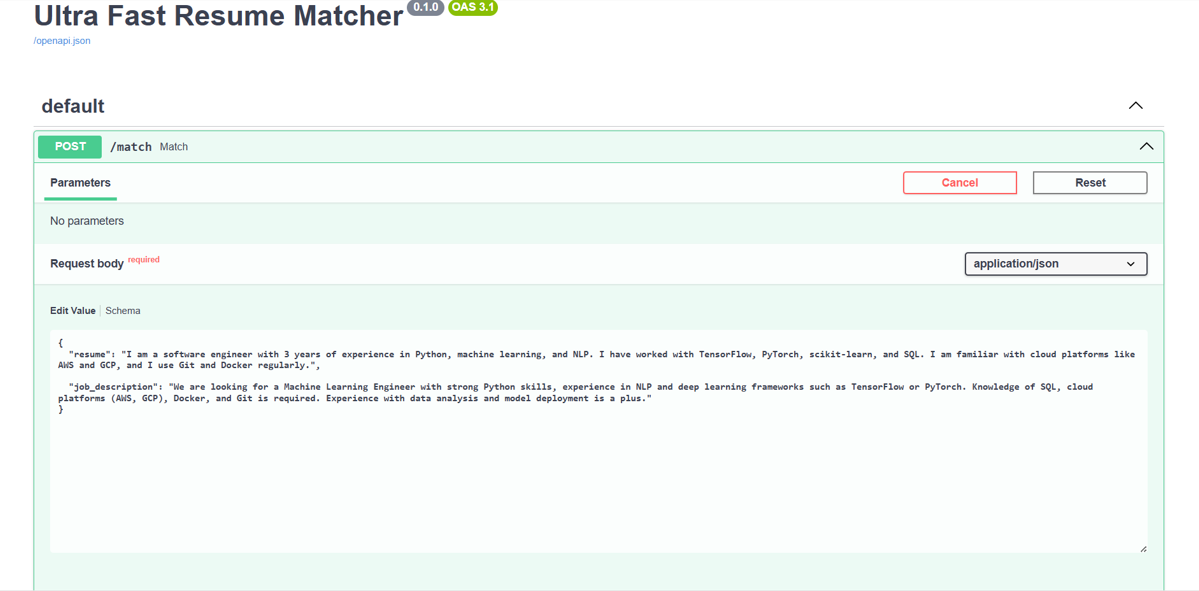

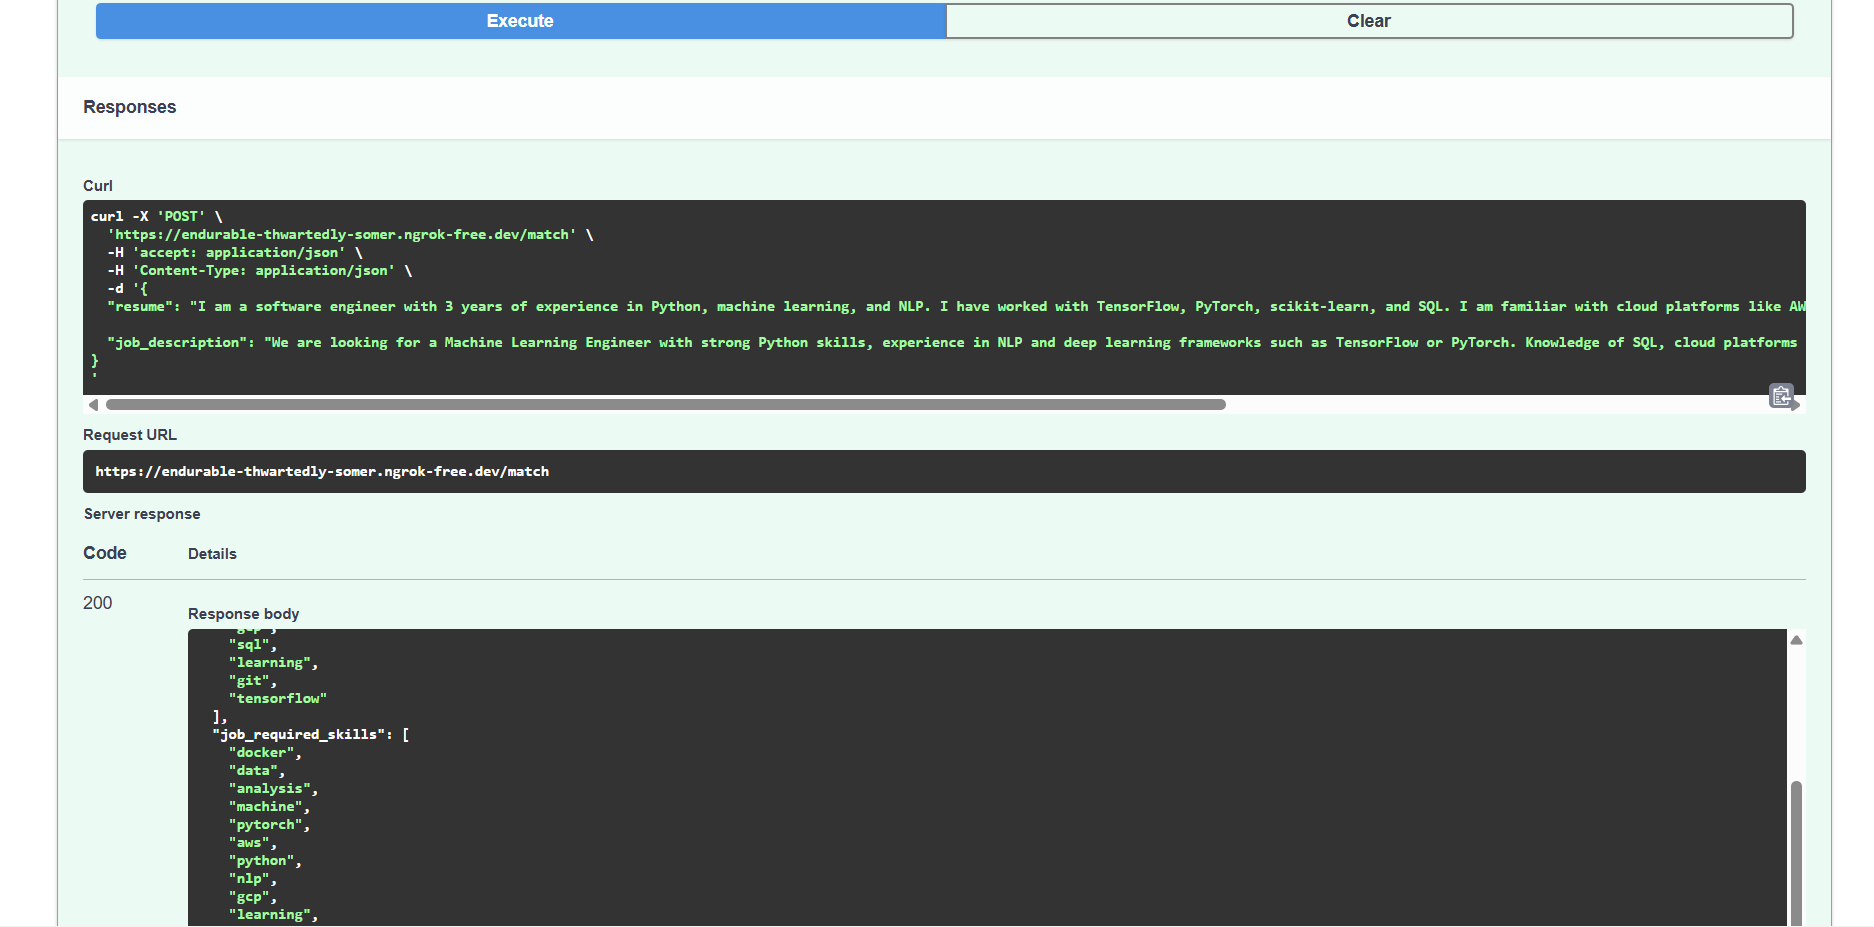

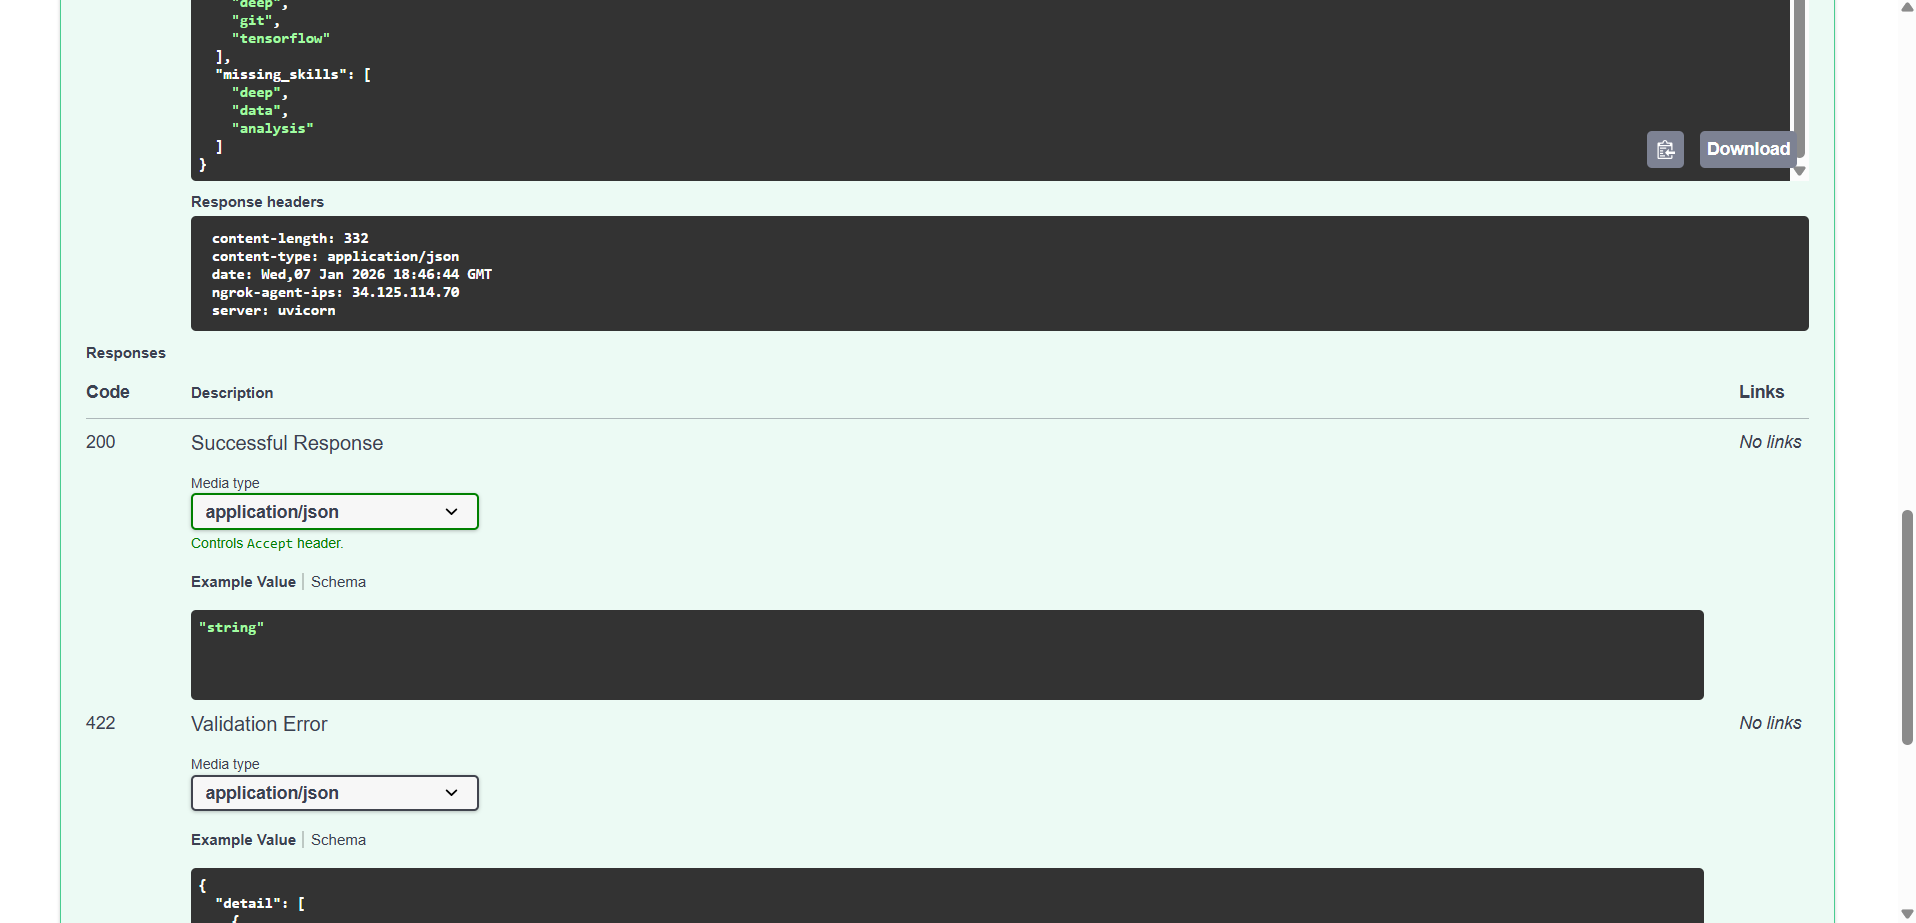

In [14]:
from IPython.display import Image, display

display(Image(filename="/content/images/part1.png"))
display(Image(filename="/content/images/part2.png"))
display(Image(filename="/content/images/part3.png"))


In [15]:
import os

for img in ["part1.png", "part2.png", "part3.png"]:
    path = f"/content/images/{img}"
    print(img, "exists:", os.path.exists(path))


part1.png exists: True
part2.png exists: True
part3.png exists: True


In [18]:
%%writefile README.md
# 🚀 Fastapi-resume-matcher

An NLP-powered backend API that semantically matches a candidate’s resume with a job description and generates an interpretable compatibility analysis.

This project demonstrates hands-on expertise in **Natural Language Processing, backend API development, and real-time deployment**, making it highly relevant for modern recruitment systems and Applicant Tracking Systems (ATS).

---

## 🎯 Project Overview

Traditional resume screening systems rely on keyword matching, which often fails to capture contextual relevance and true skill alignment.

This project addresses those limitations by:
- Understanding **semantic similarity** between resume and job description
- Automatically extracting relevant technical skills
- Identifying **missing skills** required for a role
- Producing a quantitative **match score percentage**

---

## 🧠 Core Features

- Transformer-based semantic text matching
- Automatic skill extraction from unstructured text
- Missing skill identification
- High-performance REST API using FastAPI
- Interactive API testing via Swagger UI
- Public access enabled using Ngrok

---

## 🛠️ Technology Stack

- Python
- FastAPI
- SentenceTransformers (all-MiniLM-L6-v2)
- Scikit-learn
- Uvicorn
- Ngrok
- Google Colab

---

## 🌐 Deployment Details

- Backend served using FastAPI + Uvicorn
- Public access enabled via Ngrok tunneling
- Secure environment variable handling through .env

---

## 🏞️ API Interface Screenshots



### API Input (Swagger UI)
![API Input](images/part1.png)

### API Output (Swagger UI)
![API Output](images/part2.png)

### Full Example Execution
![Example Execution](images/part3.png)


---
## 🚀 Real-World Use Cases

- Automated resume screening platforms
- Applicant Tracking Systems (ATS)
- AI-powered recruitment tools
- HR analytics solutions

---

## 🔮 Future Enhancements

- Dynamic skill extraction using Named Entity Recognition (NER)
- Ranking multiple resumes for a single job role
- Frontend dashboard using React or Streamlit
- Cloud deployment on AWS or GCP

---

## 📌 API Specification

**Endpoint:** POST /match

**Request Body (JSON example):**

\```json
{
  "resume": "Candidate resume text",
  "job_description": "Job description text"
}
\```

**Example Response (JSON):**

\```json
{
  "match_score_percent": 86.75,
  "resume_skills": ["python", "tensorflow", "git"],
  "job_required_skills": ["python", "docker", "aws"],
  "missing_skills": ["docker", "aws"]
}
\```

---

## 🏗️ Project Architecture


\```text
Client (Swagger UI / Postman) → FastAPI REST Endpoint (/match) → Text Cleaning & Normalization → SentenceTransformer Encoder → Cosine Similarity Calculation → Skill Extraction Engine → Structured JSON Response
\``

Overwriting README.md


In [12]:
from dotenv import load_dotenv
import os

load_dotenv()  # loads .env automatically

NGROK_TOKEN = os.getenv("NGROK_AUTH_TOKEN")

In [8]:
!pip install -q fastapi uvicorn nest_asyncio pyngrok sentence-transformers scikit-learn


In [9]:
import re
import nest_asyncio
import numpy as np
from fastapi import FastAPI
from pydantic import BaseModel
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from pyngrok import ngrok
import uvicorn
from dotenv import load_dotenv
import os

# ----------------
# Load .env and ngrok token
# ----------------
load_dotenv()  # automatically loads .env file
NGROK_TOKEN = os.getenv("NGROK_AUTH_TOKEN")
if not NGROK_TOKEN:
    raise RuntimeError("NGROK_AUTH_TOKEN not found! Check your .env file.")
nest_asyncio.apply()
app = FastAPI(title="Ultra Fast Resume Matcher")
model = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")
EMBED_DIM = model.get_sentence_embedding_dimension()


SKILLS = {
    "python","machine","learning","deep","nlp",
    "sql","fastapi","docker","aws","azure","gcp",
    "pandas","numpy","scikit","tensorflow",
    "pytorch","git","linux","data","analysis"
}


class MatchRequest(BaseModel):
    resume: str
    job_description: str


def clean(text: str) -> str:
    # limit text size to avoid overload
    return re.sub(r"\s+", " ", text.lower()).strip()[:3000]

def extract_skills(text: str):
    words = set(re.findall(r"\w+", text.lower()))
    return list(SKILLS.intersection(words))

@app.post("/match")
async def match(req: MatchRequest):

    resume_text = clean(req.resume)
    job_text = clean(req.job_description)


    vectors = model.encode(
        [resume_text, job_text],
        convert_to_numpy=True
    )

    score = cosine_similarity(
        [vectors[0]], [vectors[1]]
    )[0][0] * 100

    resume_skills = extract_skills(req.resume)
    job_skills = extract_skills(req.job_description)

    return {
        "match_score_percent": round(float(score), 2),
        "resume_skills": resume_skills,
        "job_required_skills": job_skills,
        "missing_skills": list(set(job_skills) - set(resume_skills))
    }


ngrok.kill()
ngrok.set_auth_token(NGROK_TOKEN)
public_url = ngrok.connect(8000).public_url
print("Swagger Docs:", public_url + "/docs")

config = uvicorn.Config(
    app,
    host="0.0.0.0",
    port=8000,
    log_level="error"
)

server = uvicorn.Server(config)

await server.serve()



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Swagger Docs: https://endurable-thwartedly-somer.ngrok-free.dev/docs
